# Анализ отзывов клиентов интернет-магазина одежды

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Этот набор данных содержит отзывы клиентов *Fashion Nova*, популярного интернет-магазина одежды. Каждая запись содержит подробную информацию об опыте рецензента в отношении бренда, включая рейтинги, заголовки отзывов, тексты отзывов и другие соответствующие метаданные. Эти данные полезны для анализа удовлетворенности клиентов, понимания настроений и выявления тенденций в отзывах пользователей с течением времени.

## Описание данных

* `Reviewer Name` - имя или псевдоним рецензента
* `Profile Link` - ссылка на профиль рецензента
* `Country` - страна рецензента
* `Review Count` - количество отзывов, представленных рецензентом
* `Review Date` - дата публикации отзыва
* `Rating` - оценка, данная рецензентом, выраженная в количестве звезд (например, "Оценка 5 из 5 звезд")
* `Review Title` - заголовок отзыва
* `Review Text` - полный текст отзыва
* `Date of Experience` - дата, когда клиент ознакомился с услугой или продуктом


**Задача**

Провести кластеризацию отзывов для анализа удовлетворенности клиентов, понимания настроений и выявления тенденций в отзывах пользователей.

* **Шаг 1.** Предобработка текста: стоп-слова, лишние символы, низко/высокочастотные слова.
* **Шаг 2.** Преобразование текста в эмбеддинги: tf-idf, word2vec, glove.
* **Шаг 3.** Снижение размерности эмбеддингов: PCA, UMAP, T-SNE.
* **Шаг 4.** Кластеризация финальных эмбеддингов: KMeans, MiniBatchKMeans, DBSCAN, HDBSCAN, AffinityPropagation, SpectralClustering.
* **Шаг 5.** Визуализировать результаты кластеризации.
* **Шаг 6.** Для каждого из полученных кластеров определите топ-5 слов, топ-5 биграмм, топ-5 документов (отзывов).
* **Шаг 7.** Найдите 5 ближайших соседей для произвольного отзыва в каждом кластере. Изучите [парные меры сходства](https://scikit-learn.org/stable/modules/metrics.html). Для оценки близости используйте косинусное расстояние.

**Рекомендации**

1. [Полезная инструкция](https://habr.com/ru/companies/oleg-bunin/articles/352614/)
2. [Сравнение текстовых документов в Python: NLP и сходство](https://sky.pro/wiki/python/sravnenie-tekstovykh-dokumentov-v-python-nlp-i-skhodstvo/)



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
from pymystem3 import Mystem

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, HDBSCAN
from yellowbrick.cluster import KElbowVisualizer, ClusteringScoreVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Прочитаем файл `fashionnova_reviews.csv` с данными в переменную `df`.

In [8]:
try:
    df = pd.read_csv('fashionnova_reviews.csv')
except:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/My Drive/fashionnova_reviews.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df.head()

,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
0,Champagne,/users/66c78240087b6269ffbcb5fb,US,1 review,2024-08-22T20:24:02.000Z,Rated 5 out of 5 stars,I love ordering from fashion nova,"I love ordering from fashion nova. The clothes are good quality as long as you read your reviews on the items so you are picking the right sizes you should be comfortable and happy, I even got my BF putting in his orders lol.","August 22, 2024"
1,Vg customer,/users/6618fdb53d4198001210cbe7,VG,3 reviews,2024-08-21T05:43:11.000Z,Rated 5 out of 5 stars,Top tier content for fashion nova,Always amazing clothes and the fast shipping is really good but let’s talk about the CLOTHES omggggg the stretchy fabrics I loveeee . If you need a quick and easy fit fashion nova is the store for you I’m an international customer trust me fashion nova will never disappoint.. love them so much,"August 18, 2024"
2,Colleen Burgher,/users/64e9595206be1a001244ff73,US,3 reviews,2024-08-21T17:09:14.000Z,Rated 5 out of 5 stars,Prices and quality of products are…,"Prices and quality of products are GREAT Would love to see a cash refund if I have to return an unused item. Bought extra items since I forget to add expedited shipping, sent an email to change shipping method and I would pay extra but no response so I ended up with double items. Other than that great job.","August 21, 2024"
3,R.G.M,/users/66c58ad1c6ab36352a08f57a,US,1 review,2024-08-21T08:36:03.000Z,Rated 5 out of 5 stars,Great customer service,Great customer service. I was helped until the Fashion Nova was able to provide a solution to my problem. I appreciate what they did for me. I love their products and I’m a very happy customer who will continue to support and buy from this brand!!!!,"August 20, 2024"
4,Rosalyn Cousar,/users/60ad4b6ef3788e001adbb8e3,US,5 reviews,2024-08-22T00:46:16.000Z,Rated 3 out of 5 stars,False advertising,Disappointing experience. You don’t live up to your advertising! BOGO should be applied to all items being purchased. If more than 2 items are part of purchase then BOGO should continue to be applied to whole purchase and all items! The advertising is false and not true. I did not read anywhere that BOGO is only to be applied once during purchase. The company is being shady!!!,"August 21, 2024"


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131980 entries, 0 to 131979
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Reviewer Name       131917 non-null  object
 1   Profile Link        131980 non-null  object
 2   Country             131976 non-null  object
 3   Review Count        131980 non-null  object
 4   Review Date         131980 non-null  object
 5   Rating              131980 non-null  object
 6   Review Title        131932 non-null  object
 7   Review Text         131980 non-null  object
 8   Date of Experience  131980 non-null  object
dtypes: object(9)
memory usage: 9.1+ MB


Оценим количество пропусков и дублткатов.

In [11]:
df['Review Text'].isnull().mean()

0.0

In [12]:
df.duplicated().sum()

66

In [13]:
df=df.drop_duplicates().reset_index(drop=True)

## Шаги 1, 2. Предобработка и векторизация данных

In [14]:
# Возьмём для анализа первые 10000 отзывов
data = pd.DataFrame(df[:10000]['Review Text'])

In [15]:
m = Mystem()
#Функция для очистки и лемматизации
def data_clear_lemmatize(text):
  text = re.sub(pattern='[^a-zA-Z ]',
                 repl=' ',
                 string=text.strip())
  return ''.join(m.lemmatize(text=text))

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [16]:
# Функция для устранения лишних пробелов и пунктуации
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())

In [17]:
data['lemm_text'] = [data_clear_lemmatize(clear_text(data['Review Text'].values[i])) for i in range(len(data['Review Text'].values))]

Векторизуем данные. Для решения задачи кластеризации представим тексты в числовом формате как `tf-idf` признаки

In [18]:
tf_idf = TfidfVectorizer(stop_words=['english'], min_df=5, max_df=0.7, ngram_range=(1, 1))

tf_idf = tf_idf.fit_transform(data['lemm_text'].values)

In [19]:
tf_idf.shape

(10000, 1640)

## Шаг 3. Снижение размерности эмбеддингов

**PCA (Principal Component Analysis)** - метод главных компонент находит только линейные комбинации исходных признаков.

Определим, какое количество компонент необходимо для сохранения 90% информации данных



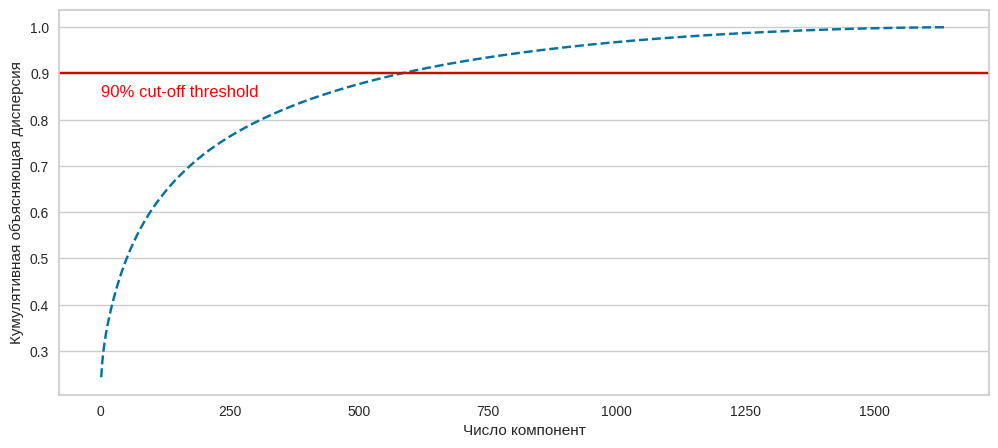

In [20]:
pca = PCA().fit(tf_idf)

plt.figure(figsize=(12, 5))
x = np.arange(1, len(pca.explained_variance_ratio_)+1,1)
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), linestyle='--', color='b')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.text(0.6, 0.85, '90% cut-off threshold', color = 'red', fontsize=12)
plt.grid(axis='x')

plt.xlabel('Число компонент')
plt.ylabel('Кумулятивная объясняющая дисперсия');

Для сохранения не менее 90% информации необходимо около 600 компонент.

In [21]:
pca_600 = PCA(n_components=600, random_state=12345)
X = pca_600.fit_transform(tf_idf)
sum(pca_600.explained_variance_ratio_)

0.904369945026162

In [22]:
# Визуализируем векторы в пространстве 3 компонент

pca_3 = PCA(n_components=3, random_state=12345)
X_pca_3 = pca_3.fit_transform(tf_idf)

fig = px.scatter_3d(
    X_pca_3, x=0, y=1, z=2,
    labels={'color': 'species'}
)
fig.update_traces(marker_size=2)
fig.show()

In [23]:
# Выделим 250 компонент
pca = PCA(n_components=250, random_state=12345)
X_emb = pca.fit_transform(tf_idf)
sum(pca.explained_variance_ratio_)

0.7637770855835648

## Шаг 4. Кластеризация эмбеддингов

Определим число кластеров методом локтя. Построим график изменения межкластерного расстояния с использованием автоматического визуализатора `KElbowVisualizer`

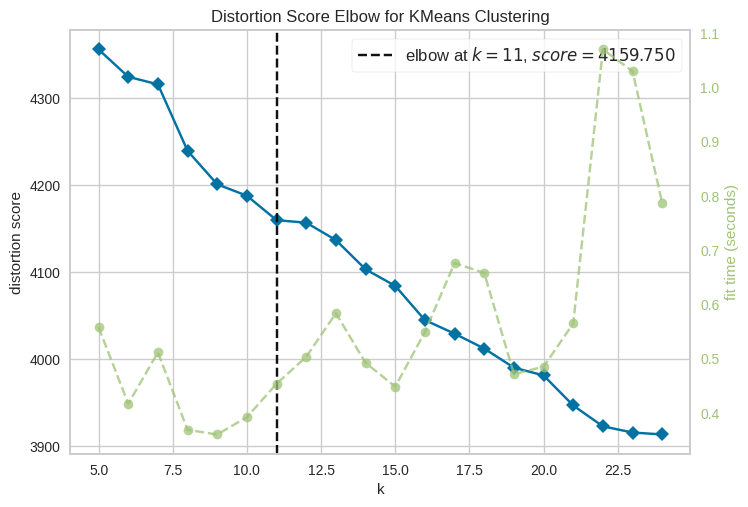

In [24]:
visual_elbow = KElbowVisualizer(KMeans(random_state = 12345, init ='k-means++'), k = (5,25))
visual_elbow.fit(X_emb)
visual_elbow.poof()
plt.show()

Оптимальное число кластеров равно 11, но для интерпретируемости результатов разьём отзывы на 5 кластеров.



In [25]:
kmeans_model = KMeans(n_clusters = 5, random_state = 12345)
labels_km = kmeans_model.fit(tf_idf).labels_
silhouette_score_km = silhouette_score(tf_idf, labels_km)
print('коэффициент силуэта равен', silhouette_score_km)

коэффициент силуэта равен 0.30098412399347485


In [26]:
def silhouette_plot(
    data: pd.DataFrame, labels: np.array, metric="euclidean", ax: plt.Axes = None
) -> None:
    """
    Функция вывода графика силуэтного скора
    :param data: данные
    :param labels: метки кластеров
    :param metric: метрика
    :return: None
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(7, 5)

    silhouette_values = silhouette_samples(data, labels, metric=metric)
    y_lower, y_upper = 0, 0

    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_values[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax.barh(
            range(y_lower, y_upper), cluster_silhouette_vals, edgecolor="none", height=1
        )
        ax.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Получение средней оценки силуэтного скора и построение графика
    avg_score = float(np.mean(silhouette_values))
    ax.axvline(avg_score, linestyle="--", linewidth=1, color="red")
    ax.set_xlabel(f"Silhouette  = {round(avg_score, 2)}")
    ax.set_ylabel("Метки кластеров")
    ax.set_title("График силуэта для различных кластеров", y=1.02)

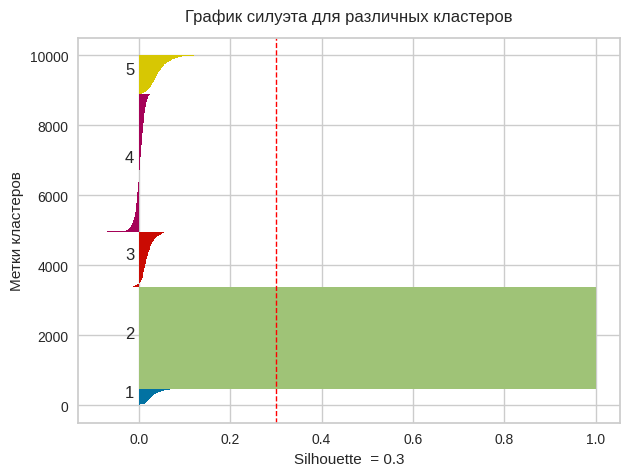

In [27]:
silhouette_plot(tf_idf, labels_km)

Видим один большой кластер и 4 примерно одинакового размера, причем имеются объекты двух кластеров, которые ближе к объектам другого кластера. Попробуем выделить 3 кластера.

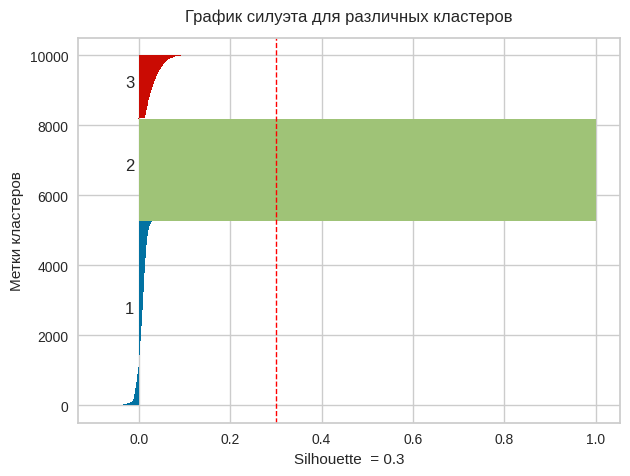

In [28]:
kmeans_model = KMeans(n_clusters = 3, init ='k-means++', random_state = 12345)
labels_km = kmeans_model.fit(tf_idf).labels_
silhouette_plot(tf_idf, labels_km)

## Шаг 5. Визуализация результатов кластеризации

Добавим метки кластеров в исходный датасет.

In [29]:
data['cluster'] = labels_km
data['cluster'].value_counts()

,count
cluster,
0,5274
1,2906
2,1820


In [30]:
fig = px.scatter_3d(
    X_pca_3, x=0, y=1, z=2,
    labels={'color': 'species'},
    color = data['cluster']
)
fig.update_traces(marker_size=2)
fig.show()

## Шаг 6. Топ-5

Для каждого из полученных кластеров определите топ-5 слов, топ-5 документов (отзывов). Найдите 5 ближайших соседей для произвольного отзыва в каждом кластере.



In [67]:
cluster_0 = data[data['cluster']==0]['lemm_text']

In [68]:
cluster_0

,lemm_text
0,I love ordering from fashion nova The clothes are good quality as long as you read your reviews on the items so you are picking the right sizes you should be comfortable and happy I even got my BF putting in his orders lol\n
1,Always amazing clothes and the fast shipping is really good but let s talk about the CLOTHES omggggg the stretchy fabrics I loveeee If you need a quick and easy fit fashion nova is the store for you I m an international customer trust me fashion nova will never disappoint love them so much\n
2,Prices and quality of products are GREAT Would love to see a cash refund if I have to return an unused item Bought extra items since I forget to add expedited shipping sent an email to change shipping method and I would pay extra but no response so I ended up with double items Other than that great job\n
3,Great customer service I was helped until the Fashion Nova was able to provide a solution to my problem I appreciate what they did for me I love their products and I m a very happy customer who will continue to support and buy from this brand\n
4,Disappointing experience You don t live up to your advertising BOGO should be applied to all items being purchased If more than items are part of purchase then BOGO should continue to be applied to whole purchase and all items The advertising is false and not true I did not read anywhere that BOGO is only to be applied once during purchase The company is being shady\n
...,...
9994,the quality is very good and I have never been disappointed shopping here\n
9995,Awesome Loved all the variety of outfits\n
9996,Love some of the clothes at FN I am older so some clothing is not suitable for me I do love what I can purchase and feel comfortable with\n
9998,Love the prices\n


In [78]:
# Создание TF-IDF матрицы заново для cluster_0
tf_idf_matrix_cluster_0 = tfidf_vectorizer.fit_transform(cluster_0)
feature_names_cluster_0 = np.array(tfidf_vectorizer.get_feature_names_out())

# --- Топ-5 слов ---
# Суммируем веса TF-IDF по всем документам
tf_idf_sum_cluster_0 = np.array(tf_idf_matrix_cluster_0.sum(axis=0)).flatten()
top_5_words_indices_cluster_0 = tf_idf_sum_cluster_0.argsort()[-5:][::-1]
top_5_words_cluster_0 = feature_names_cluster_0[top_5_words_indices_cluster_0]

# --- Топ-5 документов -/,--
# Средние веса TF-IDF для каждого документа
document_mean_tfidf_cluster_0 = np.array(tf_idf_matrix_cluster_0.mean(axis=1)).flatten()
top_5_docs_indices_cluster_0 = document_mean_tfidf_cluster_0.argsort()[-5:][::-1]
top_5_docs_cluster_0 = cluster_0.iloc[top_5_docs_indices_cluster_0]

# --- 5 ближайших соседей ---
# Выберем произвольный отзыв (например, первый)
random_review_index_cluster_0 = 0  # Первый отзыв в cluster_0
random_review_vector_cluster_0 = tf_idf_matrix_cluster_0[random_review_index_cluster_0]

# Рассчитаем косинусное сходство
cosine_similarities_cluster_0 = cosine_similarity(random_review_vector_cluster_0, tf_idf_matrix_cluster_0).flatten()
nearest_indices_cluster_0 = np.argsort(cosine_similarities_cluster_0)[-6:][::-1]  # Берем топ-6, чтобы исключить сам отзыв
nearest_indices_cluster_0 = nearest_indices_cluster_0[nearest_indices_cluster_0 != random_review_index_cluster_0][:5]
nearest_reviews_cluster_0 = cluster_0.iloc[nearest_indices_cluster_0]

# Результаты
nearest_reviews_cluster_0.values


array(['you are good thank you\n',
       'The clothes are very good material and comfortable\n',
       'Whilst the services are very good and the orders arrive on time or before the due date a word of caution Mark sure you read the return polices in FULL as you are dealing with the USA You will have to pay for the returns which might be more than the cost of the item and you will be given a credit note but NO cost refund to you credit card on back account\n',
       'I love the reviews It definitely helps with ordering the right size as clothes are made different and your regular size may not be the size you need frequent shopper\n',
       'THE PRICES ARE GREAT THE DISCOUNTS ARE GOOD AND THE CLOTHES ARE GOOD QUALITY FOR THE PRICE\n'],
      dtype=object)